<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/Elevation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author**: **Tewabe** **Melkamu**

Date: 3/10/2025

Elevation_Data Collection


In [1]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-melkatewabe')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Data** **spacification** **and** **visualization**  

In [2]:
# 1. Define the study region (Ethiopia)
# -------------------------------------------------------------------
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load and clip the SRTM DEM
# -------------------------------------------------------------------
srtm = ee.Image("CGIAR/SRTM90_V4").clip(taiwan)

# -------------------------------------------------------------------
# 3. Create a mask for water bodies
# -------------------------------------------------------------------
# Load ESA WorldCover and clip to Ethiopia.
#worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)

# Class definitions from ESA WorldCover:
# 50 = Built-up
# 80 = Permanent water bodies
# We keep only pixels that are NOT 80.
#ask = worldcover.neq(50).And(worldcover.neq(80))

# Apply this mask to the SRTM DEM
#dem_masked = srtm.updateMask(mask)

# -------------------------------------------------------------------
# 5. Visualize the data interactively
# -------------------------------------------------------------------
Map = geemap.Map(center=[23.5, 121], zoom=7)

# Original SRTM
Map.addLayer(
    srtm,
    {"min": 0, "max": 3000, "palette": ['white', 'blue', 'green', 'yellow', 'orange', 'red']},
    "Original SRTM DEM"
)

# WorldCover (for reference)
#Map.addLayer(
   # worldcover,
   # {},
   # "WorldCover (original)"
#)

# Masked DEM (no upscaling)
Map.addLayer(
    srtm,
    {"min": 0, "max": 3000, "palette": ['white', 'blue', 'green', 'yellow', 'orange', 'red']},
    "Masked SRTM DEM (Built-up & Water)"
)

# Ethiopia boundary
Map.addLayer(taiwan, {}, "Taiwan Boundary")
Map.addLayerControl()
#Map
# -------------------------------------------------------------------
# 5. Export the masked dem image to Google Drive
# -------------------------------------------------------------------
task = ee.batch.Export.image.toDrive(
    image=srtm,
    description='ELV',
    folder='Taiwan_DEM',  # Update this to your desired Drive folder.
    fileNamePrefix='ELV',
    region=taiwan.geometry().bounds().getInfo()['coordinates'],
    scale=1000,  # MODIS resolution is ~1km.
    crs='EPSG:32651',
    maxPixels=1e13
)
task.start()

print("Export task started. Check your GEE tasks and Google Drive for the exported image.")

Export task started. Check your GEE tasks and Google Drive for the exported image.


**Explor** **in** **Python**

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.5 MB/s eta 0:00:00


DEM with zeros removed saved to: /content/drive/MyDrive/Taiwan_DEM/ELV_nz.tif


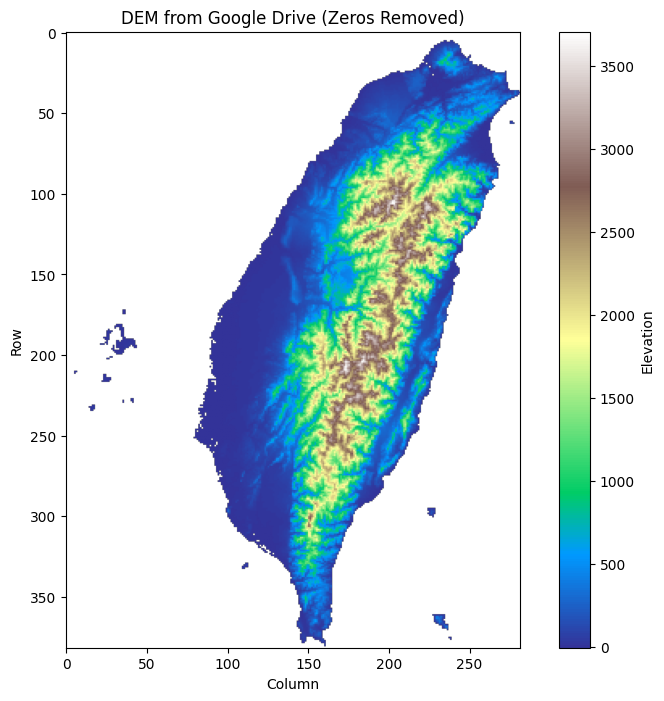

In [4]:
# Import necessary libraries
import rasterio
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Define the file path to your DEM file on Google Drive
# Update this path to match where your DEM is stored
dem_path = "/content/drive/MyDrive/Taiwan_DEM/ELV.tif"

# prompt: remove 0 elevation and  save the dem-

# Read the DEM data using rasterio and keep the dataset open
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  # Read the first band as a NumPy array
    # Get the profile while the dataset is still open
    profile = src.profile

# Assuming 'dem_data' is your NumPy array from the previous code
dem_data_no_zero = np.where(dem_data == 0, np.nan, dem_data)

# Update metadata for the output raster
profile.update(dtype=rasterio.float32, nodata=np.nan) # Update dtype and nodata

# Define the output path for the new DEM file
output_path = "/content/drive/MyDrive/Taiwan_DEM/ELV_nz.tif"

# Write the modified DEM to a new GeoTIFF file
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(dem_data_no_zero.astype(rasterio.float32), 1)

print(f"DEM with zeros removed saved to: {output_path}")

# Optional: Display the modified DEM
plt.figure(figsize=(10, 8))
plt.imshow(dem_data_no_zero, cmap="terrain")
plt.title("DEM from Google Drive (Zeros Removed)")
plt.xlabel("Column")
plt.ylabel("Row")
plt.colorbar(label="Elevation")
plt.show()

Slope calculated and saved to: /content/drive/MyDrive/Taiwan_DEM/SLP.tif


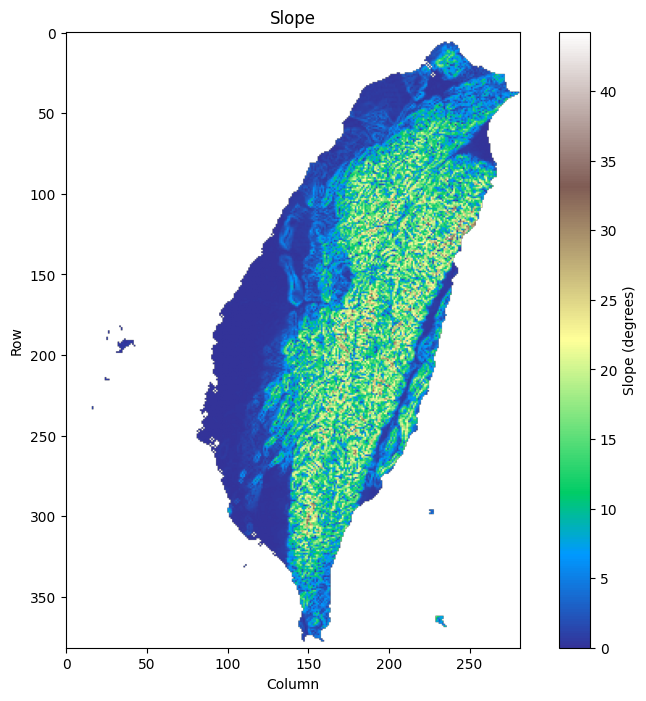

In [5]:
# prompt: generate slope and save

import matplotlib.pyplot as plt
# Calculate slope and save

import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# Input DEM file path (make sure this is correct)
input_dem = "/content/drive/MyDrive/Taiwan_DEM/ELV_nz.tif"

# Output slope file path
output_slope = "/content/drive/MyDrive/Taiwan_DEM/SLP.tif"


with rasterio.open(input_dem) as src:
    dem_data = src.read(1)
    profile = src.profile

    # Calculate the slope using NumPy gradient
    x_res = profile["transform"][0]
    y_res = -profile["transform"][4]  # Note: y-resolution is negative

    # Gradient function calculation
    slope_radians = np.arctan(np.sqrt(
        (np.gradient(dem_data, axis=0) / y_res)**2 +
        (np.gradient(dem_data, axis=1) / x_res)**2))

    slope_degrees = np.degrees(slope_radians)

    # Update metadata for the output raster
    profile.update(dtype=rasterio.float32, nodata=np.nan, count=1)

    # Write the slope to a new GeoTIFF file
    with rasterio.open(output_slope, "w", **profile) as dst:
        dst.write(slope_degrees.astype(rasterio.float32), 1)

print(f"Slope calculated and saved to: {output_slope}")

#Optional: Display the slope
plt.figure(figsize=(10, 8))
plt.imshow(slope_degrees, cmap="terrain")
plt.title("Slope")
plt.xlabel("Column")
plt.ylabel("Row")
plt.colorbar(label="Slope (degrees)")
plt.show()


Metadata:
driver: GTiff
dtype: int16
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


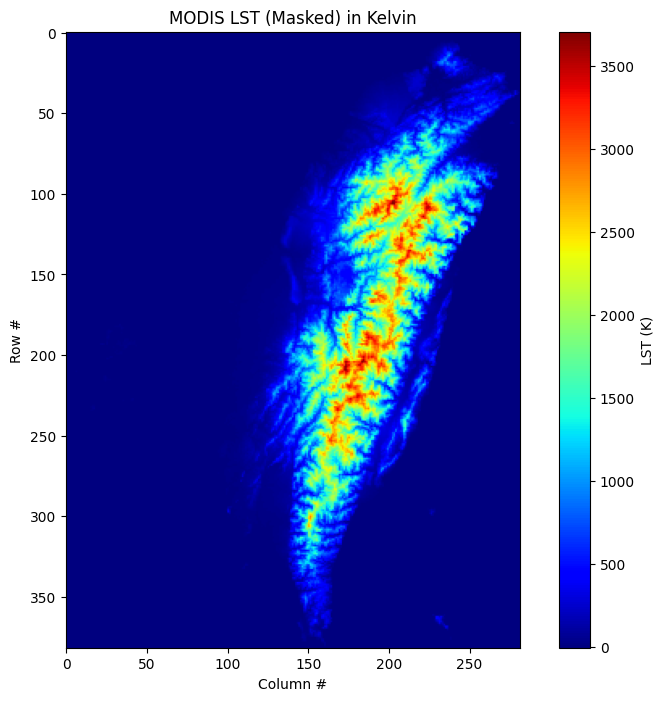

In [7]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/Taiwan_DEM/ELV.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
ndvi_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(ndvi_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST (Masked) in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()